Main steps in ML
- *Data collection*
- *Data Preprocessing* - drop missing data
- *Exploratory Data Analysis (EDA)* - visualize data to define relationship between the factor
- *Feature Engineering* - select feature, normalization, train-test split
- *Model Training* - build custom model and train data with the model 
- *Model Evaluation* - perform validations and evaluate model performance using metrics 
- *Hyperparameter Tuning* - to find the best parameter values for the model to get the best result.

This mini project is to showcase how machine learning learn patterns from time series (also known as sequential) data. 
- Project Title: Stock Prediction using deep learning model Long-short term memory (LSTM) and ML Models linear regressions and random forest.
- Feature Selected: Adjusted Close, Highest price in a day, lowest price in a day, starting price of a day, 'RSI', 'EMA20', 'EMA100', 'EMA150'
- Target: Price changes of a day (Adjusted Close - Open)
- Model Evaluation: offset 7 units in price. Not ideal. Linear regression and random forest has better results (4 unit offset)

Limitation
Not accurate result. Less features that might impact to the price. The model is just depends on the historical price.
- can add sentiment analysis as one of the input features (from social media)
- can try binary classification (set target as up/down, define sigmoid activation function at the output layer 0,1)
- can try with other machine learning model
- this dataset is not friendly to use, can play other popular topic such as heart disease diagnosis, house price prediction, leaf disease classification (image) that have larger datasets and more features if interested. The public free dataset can be found in kaggle/ hugging face.




## Library imports

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_ta as ta
import matplotlib.dates as mdates
import ta 
import os
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from curl_cffi import requests

Option 1 to download data from yahoo finance public financial dataset
- got RateLimitError (too many requests) without any causing. sometimes, hit only once but get the error. If encounter this issue, go to option 2.

- can put other ticker MSFT AAPL GOOG

In [ ]:

# # tesla_data = yf.download('TSLA', period="max", auto_adjust=False)
# tesla_data.tail()

Option 2

In [ ]:
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker("TSLA", session=session)
tesla_data = ticker.history(period='max', auto_adjust=False)
tesla_data

# Remove timezone 2010-06-29 00:00:00-04:00	
tesla_data.index = pd.to_datetime(tesla_data.index, utc=True)
tesla_data.index = tesla_data.index.tz_localize(None)
tesla_data.index = tesla_data.index.strftime('%Y-%m-%d')
tesla_data

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,0.0,0.0
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,0.0,0.0
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,0.0,0.0
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,0.0,0.0
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-05-07,276.880005,277.920013,271.000000,276.220001,276.220001,71592600,0.0,0.0
2025-05-08,279.630005,289.799988,279.410004,284.820007,284.820007,97539400,0.0,0.0
2025-05-09,290.209991,307.040009,290.000000,298.260010,298.260010,132387800,0.0,0.0


In [514]:
today = datetime.today().strftime('%Y-%m-%d')
file_path = os.path.join("data", f"TSLA_stock_data"+today+".csv")
tesla_data.to_csv(file_path)

## Load Data

In [546]:
# tesla_data=pd.read_csv(file_path, index_col=0, parse_dates=True)
tesla_data=pd.read_csv(file_path, index_col=0)
tesla_data

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,0.0,0.0
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,0.0,0.0
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,0.0,0.0
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,0.0,0.0
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-05-07,276.880005,277.920013,271.000000,276.220001,276.220001,71592600,0.0,0.0
2025-05-08,279.630005,289.799988,279.410004,284.820007,284.820007,97539400,0.0,0.0
2025-05-09,290.209991,307.040009,290.000000,298.260010,298.260010,132387800,0.0,0.0


## 2.0 Preprocess Data
- handle missing data
- handle 
- categorical encoding (one-hot, ordinal, nominal)
- feature selection (strong relationship)
- normalization because larger values might affect the training process and it helps avoid numerical instability and improves model accuracy

In [547]:
# convert to numeric to add new indicators
for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
    tesla_data[col] = pd.to_numeric(tesla_data[col], errors='coerce')

print(tesla_data.dtypes)

Open            float64
High            float64
Low             float64
Close           float64
Adj Close       float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object


In [548]:
# tesla_data.index = pd.to_datetime(tesla_data.index)
# Calculate the new technical indicators
tesla_data['RSI'] = ta.momentum.rsi(tesla_data['Close'], window=14)  # Relative Strength Index
tesla_data['EMA20'] = ta.trend.ema_indicator(tesla_data['Close'], window=20)  # 20-period Exponential Moving Average
tesla_data['EMA100'] = ta.trend.ema_indicator(tesla_data['Close'], window=100)  # 100-period Exponential Moving Average
tesla_data['EMA150'] = ta.trend.ema_indicator(tesla_data['Close'], window=150)  # 150-period Exponential Moving Average

tesla_data['Target'] = tesla_data['Adj Close'] - tesla_data['Open'] # daily price movement
tesla_data['Target'] = tesla_data['Target'].shift(-1)  # Shift 1 row up, means today's features will correspond to tomorrow’s price movement.
# tesla_data['TargetClass'] = [1 if tesla_data['Target'][i] > 0 else 0 for i in range(len(tesla_data))]  # Binary classification target
# tesla_data['TargetNextClose'] = tesla_data['Adj Close'].shift(-1)  # Target variable: next day's closing price

# Drop NaN values
tesla_data.dropna(inplace=True) 
# Display the result (last 5 rows)
print(tesla_data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2025-05-06  273.109985  277.730011  271.350006  275.350006  275.350006   
2025-05-07  276.880005  277.920013  271.000000  276.220001  276.220001   
2025-05-08  279.630005  289.799988  279.410004  284.820007  284.820007   
2025-05-09  290.209991  307.040009  290.000000  298.260010  298.260010   
2025-05-12  321.989990  322.209991  311.500000  318.380005  318.380005   

               Volume  Dividends  Stock Splits        RSI       EMA20  \
Date                                                                    
2025-05-06   76715800        0.0           0.0  52.782817  268.896699   
2025-05-07   71592600        0.0           0.0  53.109681  269.594156   
2025-05-08   97539400        0.0           0.0  56.328056  271.044237   
2025-05-09  132387800        0.0           0.0  60.850423  273.636216   
2025-05-12  112826700        0.0           

In [ ]:
# Drop the columns (can decide after plot the relationship between 
# variable, skipped in this project))
tesla_data.drop(columns=['Volume', 'Close', 'Dividends', 'Stock Splits'], inplace=True)  

In [550]:
tesla_data.describe()

,Open,High,Low,Adj Close,RSI,EMA20,EMA100,EMA150,Target
count,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000
mean,90.555838,92.584852,88.381715,90.531582,52.865284,89.801142,86.518227,84.502308,-0.020341
std,113.401041,115.992346,110.540946,113.306391,13.062952,112.211653,107.799842,105.384280,4.708047
min,1.452000,1.484667,1.407333,1.455333,16.564126,1.544045,1.634115,1.630344,-50.033356
25%,13.313833,13.554500,13.077333,13.331333,43.792216,13.526112,13.658369,13.704174,-0.339167
50%,19.854333,20.239666,19.466666,19.844000,51.861184,19.794336,20.081342,19.810602,-0.000333
75%,194.419998,198.779999,189.924999,194.699997,61.804049,193.284966,198.087870,200.832587,0.345001
max,475.899994,488.540009,457.510010,479.859985,94.197983,414.240657,346.705625,321.414580,47.510010


In [551]:
tesla_df = tesla_data[['Target']].copy()
tesla_df

,Target
Date,
2011-01-31,-0.026667
2011-02-01,-0.014667
2011-02-02,-0.012667
2011-02-03,0.001333
2011-02-04,-0.012667
...,...
2025-05-06,-0.660004
2025-05-07,5.190002
2025-05-08,8.050018


In [552]:
features = ['Adj Close', 'High', 'Low', 'Open', 'RSI', 'EMA20', 'EMA100', 'EMA150']
scaler_features = MinMaxScaler(feature_range=(0,1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(tesla_data[features])
scaled_target = scaler_target.fit_transform(tesla_data[['Target']])

In [553]:
def create_sequences(scaled_features, scaled_target, sequence_length=60):
    # LSTM work by processing sequences of data
    # Create sequences of data for training
    # e.g. [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55
    # X = [ [0.1 0.15 0.2], [0.15 0.2 0.25], ...]
    # y = [ 0.25 0.3 ]
    X, y = [], [] # input seq, target values
    for i in range(len(scaled_features) - sequence_length):
        X.append(scaled_features[i:i+sequence_length])
        y.append(scaled_target[i+sequence_length])

    return np.array(X), np.array(y)

Split to Train & Test Sets

In [554]:
# LSTM need sequence length
sequence_length = 60
X, y = create_sequences(scaled_features, scaled_target, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2825, 60, 8)
X_test shape: (707, 60, 8)
y_train shape: (2825, 1)
y_test shape: (707, 1)


## 3.0 Build LSTM Model
- build custom model structure
- perform model training
- LSTM intro (https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce)
- LSTM parameters (https://keras.io/api/layers/recurrent_layers/lstm/)
- optimizer (https://keras.io/api/optimizers/)

In [ ]:
# feed a sequence of 60 previous stock prices
# input shape (sequence length, features)
lstm_model = Sequential([
    LSTM(unit=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), #sequence length, feature size 
    Dropout(0.2),
    LSTM(unit=32, return_sequences=False),  
    Dense(1)
])


lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
lstm_model.summary()


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Early Stopping

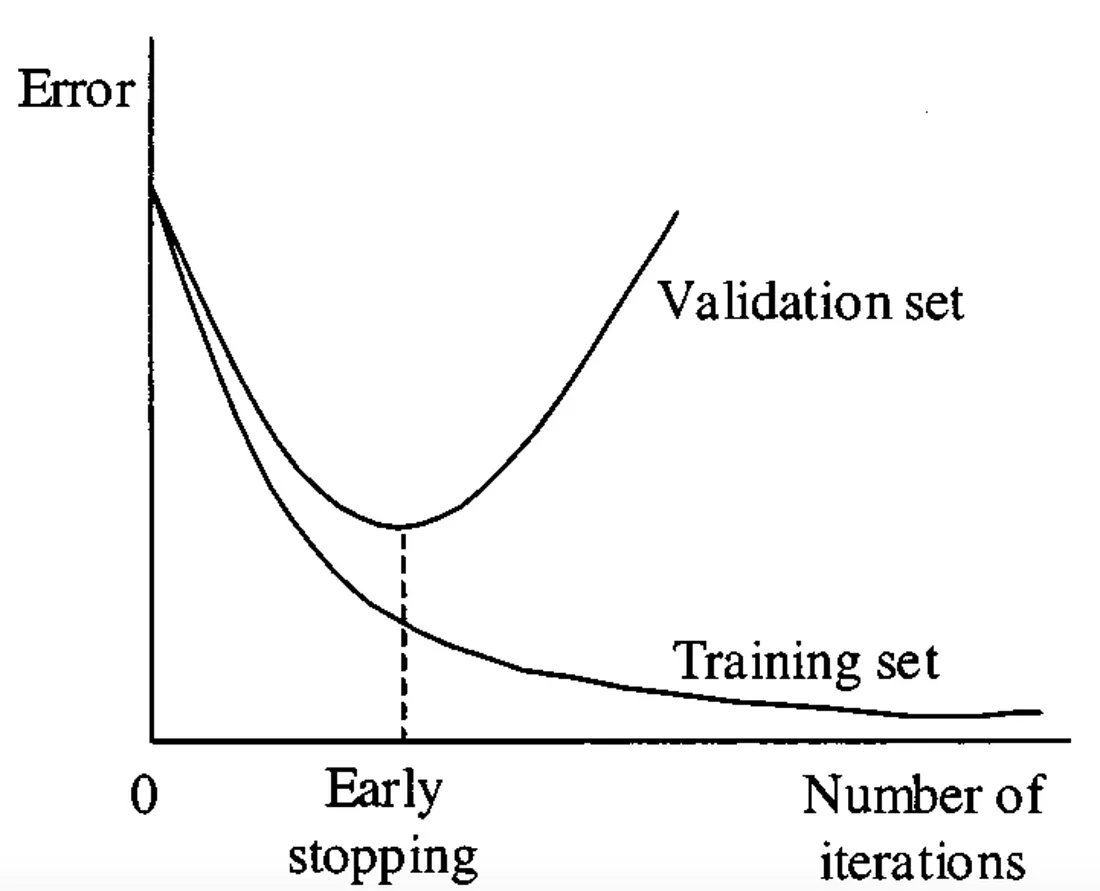

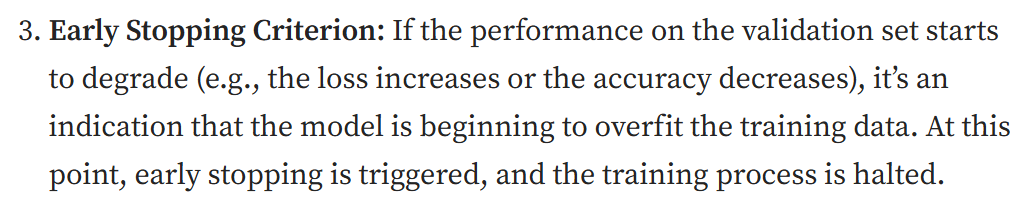

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# fit() used to train the model
# take training data to learn patterns by adjusting internal parameters
# verbose=1 show the training progress
history = lstm_model.fit(X_train, y_train,
               epochs=100,
               batch_size=16,
               validation_data=(X_test, y_test),
               callbacks=[early_stopping],
               verbose=1)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - 

In [471]:
def filename_to_save(folder):
    os.makedirs(folder, exist_ok=True)

    today = datetime.now().strftime("%Y-%m-%d")

    existing_files = [f for f in os.listdir(folder) if f.startswith(today) and f.endswith('.png')]
    next_number = len(existing_files) + 1

    # Filename with increment
    filename = f"{today}_{next_number}.png"
    full_path = os.path.join(folder, filename)
    print(f"Saving as: {full_path}")
    return full_path

def save_model(model, folder):
    os.makedirs(folder, exist_ok=True)

    today = datetime.now().strftime("%Y-%m-%d")

    existing_files = [f for f in os.listdir(folder) if f.startswith(today) and f.endswith('.h5')]
    next_number = len(existing_files) + 1

    # Filename with increment
    filename = f"{today}_{next_number}.h5"
    full_path = os.path.join(folder, filename)

    print(f"Saving as: {full_path}")
    model.save(full_path)
    return full_path

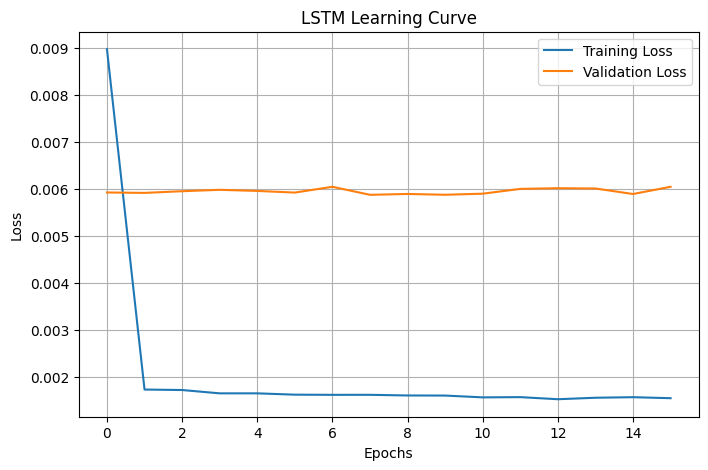

Saving as: image/learning_curve\2025-05-15_1.png


<Figure size 640x480 with 0 Axes>

In [177]:
# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Learning Curve')
plt.legend()
plt.grid()
plt.show()

saving_path = filename_to_save("image/learning_curve")
plt.savefig(saving_path)

In [178]:
# save model
saved_model = save_model(lstm_model, "model")

Saving as: model\2025-05-15_1.h5


In [179]:
loaded_model = load_model(saved_model)

## 4.0 Model Evaluation

In [ ]:
# Make predictions
test_predictions = loaded_model.predict(X_test)
test_predictions = scaler_target.inverse_transform(test_predictions)
y_test_actual = scaler_target.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae: .2f}')
print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')
# These metrics is used to get the average of (absolute/squared/square root) differences between predicted and actual prices.
# values the lower the better
# Mean Absolute Error = model's predictions are off by $5.47 from the actual price movement in the day
# Mean Squared Error = mistakes are squared, so larger errors have a bigger impact
# Root Mean Squared Error = model's predictions are off by $7.23 from the actual price movement in the day

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Absolute Error (MAE):  5.47
Mean Squared Error (MSE):  55.90
Root Mean Squared Error (RMSE):  7.48


C:\Users\USER\AppData\Local\Temp\ipykernel_27376\4212246578.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100


Saving as: image/test_result\2025-05-15_1.png


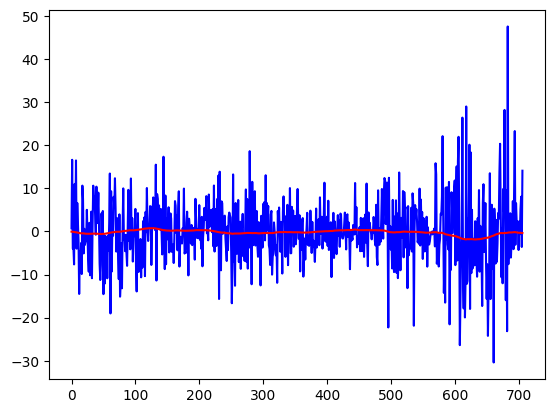

In [ ]:
# forgot to put title: price movement per day
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(test_predictions, label='Predicted Prices', color='red')

saving_path = filename_to_save("image/test_result")
plt.savefig(saving_path)

In [182]:
tesla_data

,Open,High,Low,Adj Close,RSI,EMA20,EMA100,EMA150,Target
Date,,,,,,,,,
2011-01-31,1.603333,1.608000,1.566667,1.606667,38.974381,1.704250,1.728221,1.680878,-0.026667
2011-02-01,1.620667,1.648667,1.569333,1.594000,38.169562,1.693750,1.725563,1.679728,-0.014667
2011-02-02,1.610667,1.612000,1.578000,1.596000,38.385900,1.684441,1.722997,1.678619,-0.012667
2011-02-03,1.588000,1.593333,1.543333,1.575333,36.947269,1.674049,1.720073,1.677251,0.001333
2011-02-04,1.562667,1.578000,1.548000,1.564000,36.147241,1.663569,1.716983,1.675751,-0.012667
...,...,...,...,...,...,...,...,...,...
2025-05-06,273.109985,277.730011,271.350006,275.350006,52.782817,268.896699,292.811814,292.257441,-0.660004
2025-05-07,276.880005,277.920013,271.000000,276.220001,53.109681,269.594156,292.483263,292.045025,5.190002
2025-05-08,279.630005,289.799988,279.410004,284.820007,56.328056,271.044237,292.331516,291.949329,8.050018


## 5.0 Future Predictions

In [183]:
def future_predictions(features, scaler_features, scaler_target, sequence_length=60, days_to_predict=15):
    # Prepare data for future prediction
    # Get the last sequence of 
    # for prediction (10 features at the last 90 time steps)
    last_sequence = tesla_data[features].values[-sequence_length:]
    last_sequence_scaled = scaler_features.transform(last_sequence)

    current_sequence = last_sequence.copy()
    current_sequence = last_sequence_scaled.reshape(1, sequence_length, len(features))
    
    # Predict future prices
    future_predictions = []
    print(f"\nPredicting Tesla stock for the next {days_to_predict} days...")

    for _ in range(days_to_predict):
        # Get next predicted value
        next_pred = lstm_model.predict(current_sequence, verbose=1)  # Predicting based on current_sequence
        # Append predicted value (only the target value) to predictions
        future_predictions.append(next_pred[0, 0])  # Assuming you're predicting the target value
        # We need to create a new data point with all features to add to the sequence
        # For simplicity, we'll duplicate the last day's features and update with our prediction
        # In a real scenario, you would use more sophisticated methods to estimate feature values
        new_point = last_sequence_scaled[-1:].copy()
        
        # Update the sequence by removing first timepoint and adding new point at the end
        # First reshape current_sequence to 2D, remove first row, then reshape back to 3D
        current_sequence = current_sequence.reshape(sequence_length, len(features))
        current_sequence = np.vstack([current_sequence[1:], new_point])
        current_sequence = current_sequence.reshape(1, sequence_length, len(features))

    # Inverse transform the scaled predictions to get actual price values
    future_predictions_array = np.array(future_predictions).reshape(-1, 1)
    future_pred = scaler_target.inverse_transform(future_predictions_array)

    # Create dates for future predictions (skipping weekends would be more accurate)
    last_date = pd.to_datetime(tesla_data.index[-1])
    future_dates = []
    
    for i in range(days_to_predict):
        next_date = last_date + timedelta(days=i+1)
        # Skip weekends (simple approach, doesn't account for holidays)
        while next_date.weekday() > 4:  # 5 = Saturday, 6 = Sunday
            next_date = next_date + timedelta(days=1)
        future_dates.append(next_date)
    
    # Create a DataFrame for the predictions
    forecast_df = pd.DataFrame({
        'Date': [date.strftime('%Y-%m-%d') for date in future_dates],
        'Predicted_Price_Change': future_pred.flatten()
    })
    forecast_df.set_index('Date', inplace=True)
    
    # Print forecast results
    print(f"\nTesla (TSLA) {days_to_predict}-Day Forecast:")
    print(f"{'Date':<12} | {'Predicted Price Change':>20}")
    print("-" * 35)
    for date, price_change in zip(forecast_df.index, forecast_df['Predicted_Price_Change']):
        direction = "🔼" if price_change > 0 else "🔽"
        print(f"{date:<12} | ${price_change:>18.2f} {direction}")
    return forecast_df


In [184]:
forecast_df = future_predictions(features, scaler_features, scaler_target)


Predicting Tesla stock for the next 15 days...


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Tesla (TSLA) 15-Day Forecast:
Date         | Predicted Price Change
-----------------------------------
2025-05-13   | $             -0.43 🔽
2025-05-14   | $             -0.48 🔽
2025-05-15   | $             -0.51 🔽
2025-05-16   | $             -0.54 🔽
2025-05-19   | $             -0.55 🔽
2025-05-19   | $             -0.57 🔽
2025-05-19   | $             -0.58 🔽
2025-05-20   | $             -0.59 🔽
2025-05-21   | $            

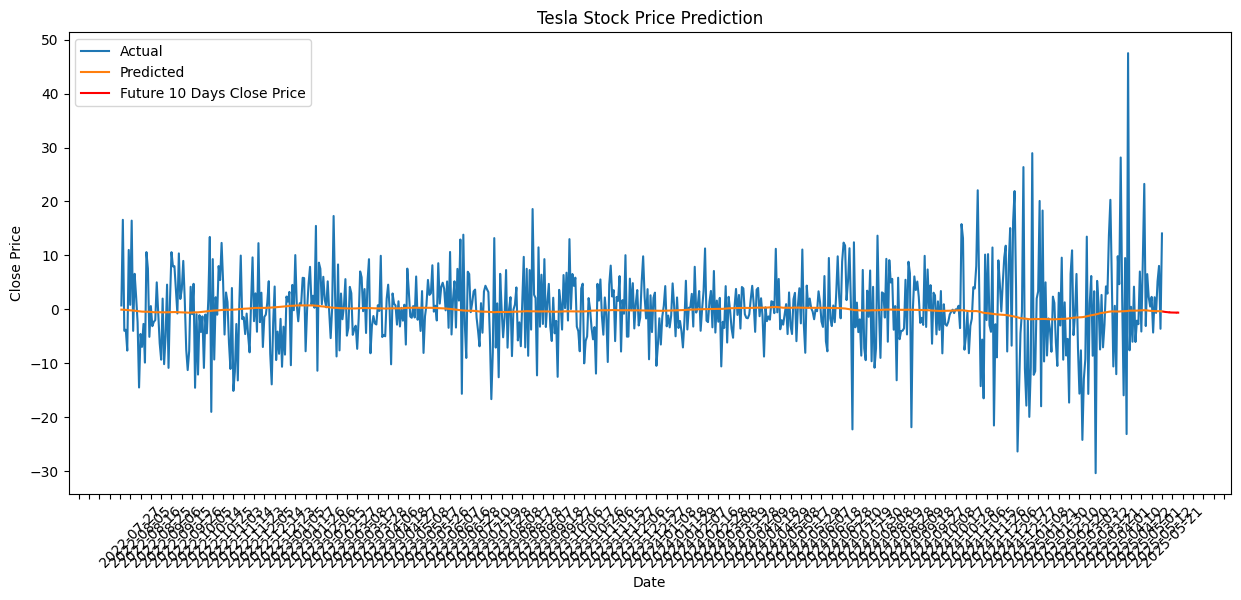

Saving as: image/future_prediction\2025-05-15_1.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Get the dates corresponding to the test data
test_dates = tesla_data.index[len(X_train) + sequence_length:]
# test_dates = test_dates.tz_localize(None)
# test_dates = test_dates.strftime('%Y-%m-%d')

# y_test_actual = scaler.inverse_transform(y_test)

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_actual, label='Actual')
plt.plot(test_dates, test_predictions, label='Predicted')
plt.plot(forecast_df.index, forecast_df['Predicted_Price_Change'], 'r-', label='Future 10 Days Close Price')

# plt.plot(test_dates, y_test_actual, label='Actual')
# plt.plot(test_dates, test_predictions, label='Predicted')
# plt.plot(forecast_df.index, forecast_df['Predicted_Close'], 'r-', label='Future 15 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Price Movement')
plt.title('Tesla Stock Price Movement Prediction')
plt.legend()
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.show()
saving_path = filename_to_save("image/future_prediction")
plt.savefig(saving_path)

## 6.0 Hyperparameter Fine-tuning

In [ ]:
# Tune Hyperparameters to improve accuracy and reduce overfitting.
# Methods: Grid search (try every combination of hyperparameters from a 
# predefined list), random search (random combination of hyperparameters),
# bayesian optimization, use libraries like keras tuner

In [186]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2825, 60, 8)
X_test shape: (707, 60, 8)
y_train shape: (2825, 1)
y_test shape: (707, 1)


In [ ]:
# see how many layers in the model
base_model = loaded_model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  4


In [ ]:
# can use this when a few layers in the model and 
# you want to tune with a fixed number of layers

# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
# means that freeze the first layer and tune the other layers
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,139 (121.64 KB)

 Trainable params: 12,449 (48.63 KB)

 Non-trainable params: 18,688 (73.00 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
def build_model(hp):
    # Hyperparameter options
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    hp_layers = hp.Int('num_layers', 1, 3)  # Number of LSTM layers, 1 to 3
    hp_dropout = hp.Float('dropout_rate', 0.1, 0.5, step=0.1) 
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]) #0.01 to 0.00001
    hp_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    
    model = Sequential()
    
    # Add LSTM layers with return_sequences=True except last layer
    for i in range(hp_layers):
        model.add(LSTM(
            units=hp_units,
            activation='tanh', # default is sigmoid
            return_sequences=i < hp_layers-1,
            input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None
        ))
        model.add(Dropout(hp_dropout))
    
    # Final Dense layers
    model.add(Dense(hp.Int('dense_units', 16, 64, step=16)))
    model.add(Dense(1))
    
    # Optimizer configuration
    optimizer_config = {
        'adam': optimizers.Adam,
        'rmsprop': optimizers.RMSprop,
        'sgd': optimizers.SGD
    }
    
    optimizer = optimizer_config[hp_optimizer](learning_rate=hp_learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

In [190]:
import keras_tuner
tuner = keras_tuner.GridSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=15,
    executions_per_trial=1,
    directory='tuning',
    project_name='stock_prediction',
    max_consecutive_failed_trials=20
)
tuner.search_space_summary()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [191]:
import keras_tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning',
    project_name='stock_prediction',
    max_consecutive_failed_trials=20,
    overwrite=True
)
tuner.search_space_summary()

Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop', 'sgd'], 'ordered': False}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}


In [ ]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, 
             validation_data=(X_test, y_test),
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])
tuner.results_summary()
# ignore the result below, reruns but had been stopped manually

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |192               |units
2                 |2                 |num_layers
0.3               |0.3               |dropout_rate
0.01              |0.01              |learning_rate
sgd               |sgd               |optimizer
16                |16                |dense_units




Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0468 - mean_absolute_error: 0.1506 - val_loss: 0.0067 - val_mean_absolute_error: 0.0604
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0041 - mean_absolute_error: 0.0430 - val_loss: 0.0065 - val_mean_absolute_error: 0.0597
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0034 - mean_absolute_error: 0.0405 - val_loss: 0.0063 - val_mean_absolute_error: 0.0589
Epoch 4/100
15/89 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0023 - mean_absolute_error: 0.0353

KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps_summary = best_hps.values
print("Best Hyperparameters:",best_hps_summary)

Best Hyperparameters: {'units': 160, 'num_layers': 1, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'optimizer': 'adam', 'dense_units': 16}


In [ ]:
# Extract the best hyperparameters
best_optimizer = best_hps.get('optimizer')
best_learning_rate = best_hps.get('learning_rate')
best_units = best_hps.get('units')
best_layers = best_hps.get('num_layers')
best_dropout = best_hps.get('dropout_rate')
best_dense_units = best_hps.get('dense_units')

#  Map optimizer string to actual optimizer class
optimizer_classes = {
    'adam' : optimizers.Adam,
    'sgd': optimizers.SGD,
    'rmsprop': optimizers.RMSprop,
    'adagrad': optimizers.Adagrad,
    'adadelta': optimizers.Adadelta,
    'adamax': optimizers.Adamax
}
best_optimizer_class = optimizer_classes[best_optimizer]

# Build the model using the best hyperparameters
tuned_model = Sequential()
for i in range(best_layers):
    tuned_model.add(LSTM(
        units=best_units,
        activation='tanh',
        return_sequences=i < best_layers-1,
        input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None
    ))
    tuned_model.add(Dropout(best_dropout))
    tuned_model.add(Dense(best_dense_units, activation='relu'))
    tuned_model.add(Dense(1))
    
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
tuned_model.compile(optimizer=best_optimizer_class(learning_rate=best_learning_rate),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
tuned_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 160)            │       108,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,753 (432.63 KB)

 Trainable params: 110,753 (432.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fine_tune_epochs = 50
total_epochs =  len(history.epoch) + fine_tune_epochs

history_fine = tuned_model.fit(X_train, y_train,
               epochs=total_epochs,
               initial_epoch=len(history.epoch),
               validation_data=(X_test, y_test),
               callbacks=[early_stopping],
               verbose=1)

Epoch 17/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 18/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 19/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 20/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 21/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 22/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 23/66
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.00

In [ ]:
def plot_history2(history: object, history2: object):
    epochs_range = range(1, len(history.history['loss'])+len(history2.history['loss'])+1)
    plt.figure(num='Training Result', figsize=(12, 6))

    loss = history.history['loss'] + history2.history['loss']
    val_loss = history.history['val_loss'] + history2.history['val_loss']

    # Subchart 2
    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range,
             val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot([len(history.history['loss']),len(history.history['loss'])],
    plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    # Space adjustments
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    saving_path = filename_to_save("image/fine_tune_curve")
    plt.savefig(saving_path)

In [ ]:
plot_history2(history,history_fine)

<IPython.core.display.Javascript object>

Saving as: image/fine_tune_curve\2025-05-14_1.png


In [ ]:
# Make predictions
test_predictions2 = tuned_model.predict(X_test)
test_predictions2 = scaler_target.inverse_transform(test_predictions2)
y_test_actual2 = scaler_target.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual2, test_predictions2)
mse = mean_squared_error(y_test_actual2, test_predictions2)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae: .2f}')
print(f'Mean Squared Error (MSE): {mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rmse: .2f}')

# worst result than the base model

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Absolute Error (MAE):  6.09
Mean Squared Error (MSE):  67.58
Root Mean Squared Error (RMSE):  8.22


In [ ]:
forecast_df2 = future_predictions(features, scaler_features, scaler_target)


Predicting Tesla stock for the next 15 days...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Tesla (TSLA) 15-Day Forecast:
Date         | Predicted Price Change
-----------------------------------
2025-05-13   | $             -0.18 🔽
2025-05-14   | $             -0.19 🔽
2025-05-15   | $             -0.20 🔽
2025-05-16   | $             -0.21 🔽
2025-05-19   | $             -0.23 🔽
2025-05-19   | $             -0.25 🔽
2025-05-19   | $             -0.27 🔽
2025-05-20   | $             -0.28 🔽
2025-05-21   | $             -0.30 🔽
2025-05-22   | $             -0.32 🔽
2025-05-23   | $             -0.34 🔽
2025-05-26   | $             -0.35 🔽
2025-05-26   | $             -0.3

In [ ]:
# Get the dates corresponding to the test data
test_dates = tesla_data.index[len(X_train) + sequence_length:]
# test_dates = test_dates.tz_localize(None)
# test_dates = test_dates.strftime('%Y-%m-%d')

# y_test_actual = scaler.inverse_transform(y_test)

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-90:], y_test_actual2[-90:], label='Actual')
plt.plot(test_dates[-90:], test_predictions2[-90:], label='Predicted')
plt.plot(forecast_df2.index[-90:], forecast_df2['Predicted_Price_Change'][-90:], 'r-', label='Future 15 Days Close Price')

# plt.plot(test_dates, y_test_actual, label='Actual')
# plt.plot(test_dates, test_predictions, label='Predicted')
# plt.plot(forecast_df.index, forecast_df['Predicted_Close'], 'r-', label='Future 15 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.show()
saving_path = filename_to_save("image/fine_tuned_future_prediction")
plt.savefig(saving_path)

In [ ]:
today = datetime.today().date()
lstm_model.save('tesla_model/fine_model_'+str(today)+'.h5')

# 7.0 Linear Regression

In [555]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = tesla_data[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMA20', 'EMA100', 'EMA150']]  # Input features
y = tesla_data['Target']  # Target: Closing price

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict future prices
y_pred = lr_model.predict(X_test)

# Evaluate
lr_mae = mean_absolute_error(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {lr_mae: .2f}')
print(f'Mean Squared Error (MSE): {lr_mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {lr_rmse: .2f}')


Mean Absolute Error (MAE):  2.03
Mean Squared Error (MSE):  19.43
Root Mean Squared Error (RMSE):  4.41


In [557]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = X_test.index
# Convert index to datetime if not already
X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
X_test = X_test.sort_index()

# Convert y_test index to datetime if it's not already
y_test.index = pd.to_datetime(y_test.index)

# Ensure both X_test and y_test are sorted by index
y_test = y_test.sort_index()

# Now try to access y_test using X_test index
y_test_filtered = y_test.loc[X_test.index]


X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
y_pred = y_pred.sort_index()
y_pred_filtered = y_pred.loc[X_test.index]

In [558]:
# Get the latest 15 days of closing prices
tesla_data_copy = tesla_data.copy()
tesla_data_copy = tesla_data_copy.drop(columns=['Target'])
latest_data = tesla_data[['Target']].tail(10)

# Predict the next 15 days
future_prices = []
for i in range(15):
    # Reshape latest data to match the model's expected input shape
    input_data = np.array(latest_data[-8:]).reshape(1, -1)
    predicted_price = lr_model.predict(input_data)[0]  # Predict
    future_prices.append(predicted_price)  # Store prediction

    # Update latest_data with the new prediction (rolling window)
    latest_data = np.append(latest_data, predicted_price)

# Create future dates
from datetime import datetime, timedelta

last_date = pd.to_datetime(tesla_data_copy.index[-1])  # Last available date
future_dates = [last_date + timedelta(days=i+1) for i in range(15)]

# Convert predictions into a DataFrame
lr_forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices})
lr_forecast_df.set_index('Date', inplace=True)

print("\nTesla (TSLA) 5-Day Forecast Using Linear Regression:")
for date, price in zip(lr_forecast_df.index, lr_forecast_df['Predicted_Close']):
    # Ensure price is a float before formatting
    print(f"{date.strftime('%Y-%m-%d')}: ${float(price):.2f}")



Tesla (TSLA) 5-Day Forecast Using Linear Regression:
2025-05-13: $0.32
2025-05-14: $-1.67
2025-05-15: $-1.03
2025-05-16: $-1.82
2025-05-17: $-0.04
2025-05-18: $0.31
2025-05-19: $-2.78
2025-05-20: $3.03
2025-05-21: $-0.07
2025-05-22: $-0.55
2025-05-23: $-0.68
2025-05-24: $-0.88
2025-05-25: $-0.33
2025-05-26: $-0.47
2025-05-27: $-1.46


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearReg

In [559]:
lr_forecast_df.index = lr_forecast_df.index.strftime('%Y-%m-%d')

Saving as: image/linear_regression_prediction\2025-05-15_2.png


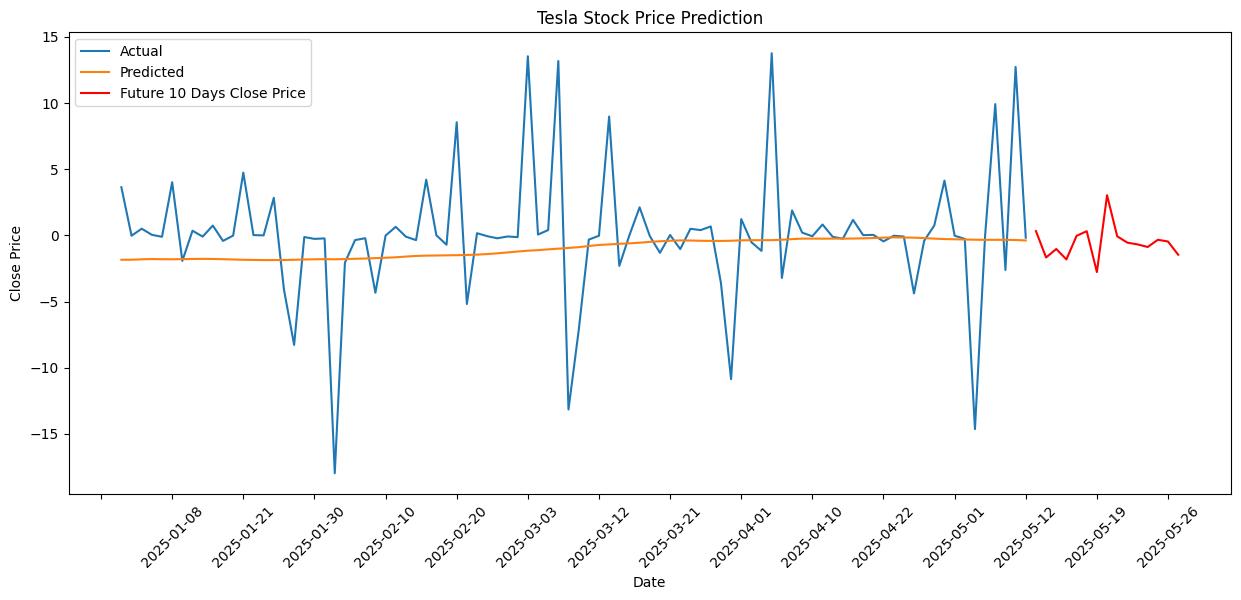

In [576]:
# Get the dates corresponding to the test data
test_dates = tesla_data.index[len(X_train) + sequence_length:]
# test_dates = test_dates.tz_localize(None)
# test_dates = test_dates.strftime('%Y-%m-%d')

# y_test_actual = scaler.inverse_transform(y_test)

# Plot the actual and predicted values against dates
plt.figure(figsize=(15, 6))
plt.plot(test_dates[-90:], y_test[-90:], label='Actual')
plt.plot(test_dates[-90:], test_predictions[-90:], label='Predicted')
plt.plot(lr_forecast_df.index[-90:], lr_forecast_df['Predicted_Close'][-90:], 'r-', label='Future 10 Days Close Price')

# plt.plot(test_dates, y_test_actual, label='Actual')
# plt.plot(test_dates, test_predictions, label='Predicted')
# plt.plot(forecast_df.index, forecast_df['Predicted_Close'], 'r-', label='Future 15 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
saving_path = filename_to_save("image/linear_regression_prediction")
plt.savefig(saving_path)
plt.show()


# 8.0 Random Forest

In [563]:
from sklearn.ensemble import RandomForestRegressor

# Features (X) and Target (y)
X = tesla_data[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMA20', 'EMA100', 'EMA150']]  # Input features
y = tesla_data['Target']  # Target: Closing price

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {rf_mae: .2f}')
print(f'Mean Squared Error (MSE): {rf_mse: .2f}')
print(f'Root Mean Squared Error (RMSE): {rf_rmse: .2f}')

Mean Absolute Error (MAE):  2.17
Mean Squared Error (MSE):  21.54
Root Mean Squared Error (RMSE):  4.41


In [466]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = X_test.index
# Convert index to datetime if not already
X_test.index = pd.to_datetime(X_test.index)

# Sort by date to get a proper line plot
X_test = X_test.sort_index()

# Convert y_test index to datetime if it's not already
y_test.index = pd.to_datetime(y_test.index)

# Ensure both X_test and y_test are sorted by index
y_test = y_test.sort_index()

# Now try to access y_test using X_test index
y_test_filtered = y_test.loc[X_test.index]

# Sort by date to get a proper line plot
y_pred = y_pred.sort_index()
y_pred_filtered = y_pred.loc[X_test.index]

In [468]:
# Get the latest 15 days of closing prices
tesla_data_copy = tesla_data.copy()
tesla_data_copy = tesla_data_copy.drop(columns=['Target'])
latest_data = tesla_data[['Target']].tail(10)

# Predict the next 15 days
future_prices = []
for i in range(15):
    # Reshape latest data to match the model's expected input shape
    input_data = np.array(latest_data[-8:]).reshape(1, -1)
    predicted_price = lr_model.predict(input_data)[0]  # Predict
    future_prices.append(predicted_price)  # Store prediction

    # Update latest_data with the new prediction (rolling window)
    latest_data = np.append(latest_data, predicted_price)

# Create future dates
from datetime import datetime, timedelta

last_date = pd.to_datetime(tesla_data_copy.index[-1])  # Last available date
future_dates = [last_date + timedelta(days=i+1) for i in range(15)]

# Convert predictions into a DataFrame
rf_forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices})
rf_forecast_df.set_index('Date', inplace=True)

print("\nTesla (TSLA) 5-Day Forecast Using Linear Regression:")
for date, price in zip(rf_forecast_df.index, rf_forecast_df['Predicted_Close']):
    # Ensure price is a float before formatting
    print(f"{date.strftime('%Y-%m-%d')}: ${float(price):.2f}")



Tesla (TSLA) 5-Day Forecast Using Linear Regression:
2025-05-13: $-0.45
2025-05-14: $-0.66
2025-05-15: $-1.11
2025-05-16: $-1.99
2025-05-17: $0.18
2025-05-18: $0.71
2025-05-19: $-3.27
2025-05-20: $3.18
2025-05-21: $-0.73
2025-05-22: $0.08
2025-05-23: $-0.77
2025-05-24: $-1.02
2025-05-25: $-0.25
2025-05-26: $-0.14
2025-05-27: $-1.65


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearReg

In [469]:
rf_forecast_df.index = rf_forecast_df.index.strftime('%Y-%m-%d')

Saving as: image/random_forest_prediction\2025-05-15_1.png


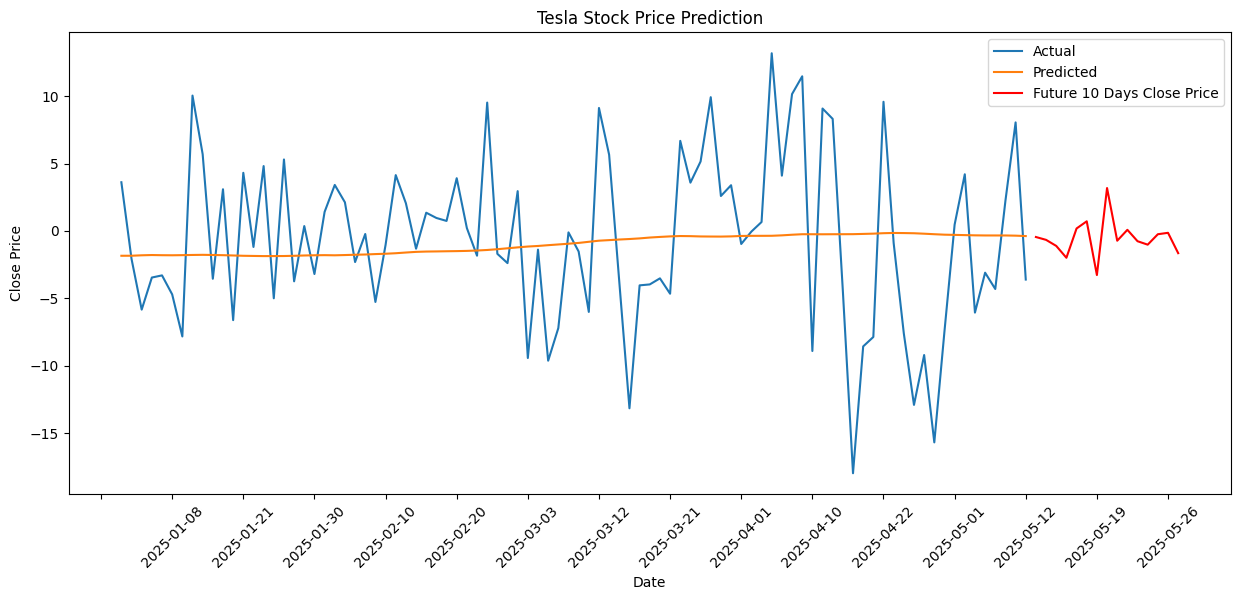

In [474]:
# Get the dates corresponding to the test data
test_dates = tesla_data.index[len(X_train) + sequence_length:]

plt.figure(figsize=(15, 6))
plt.plot(test_dates[-90:], y_test[-90:], label='Actual')
plt.plot(test_dates[-90:], test_predictions[-90:], label='Predicted')
plt.plot(rf_forecast_df.index[-90:], rf_forecast_df['Predicted_Close'][-90:], 'r-', label='Future 10 Days Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
saving_path = filename_to_save("image/random_forest_prediction")
plt.savefig(saving_path)
plt.show()


## Comparison
- LSTM
- Linear Regression
- Random Forest

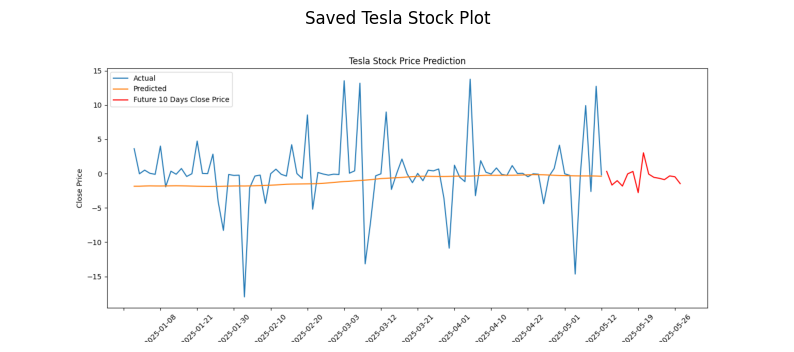

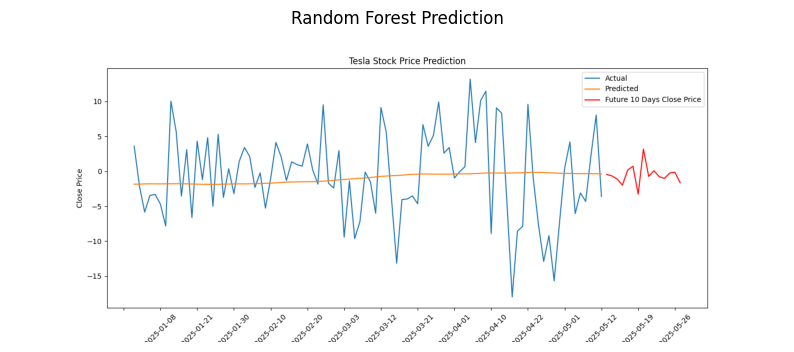

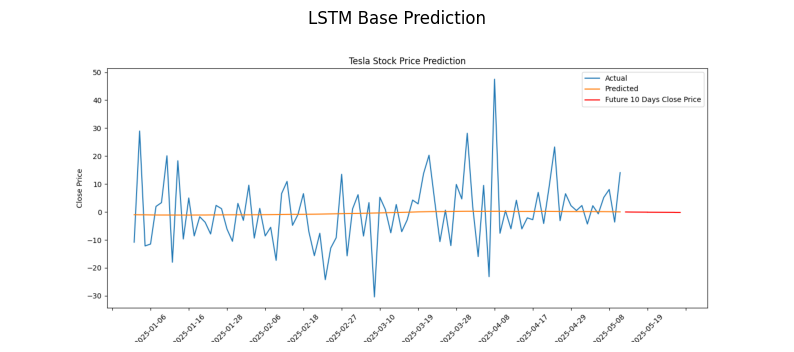

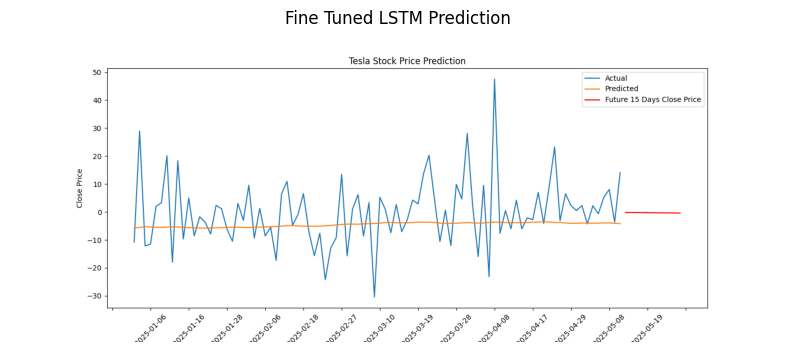

In [578]:
import matplotlib.image as mpimg
img1 = mpimg.imread('image/linear_regression_prediction/2025-05-15_2.png') 
img2 = mpimg.imread('image/random_forest_prediction/2025-05-15_1.png') 
img3 = mpimg.imread('image/future_prediction/2025-05-14_3.png')
img4 = mpimg.imread('image/fine_tuned_future_prediction/2025-05-14_5.png')

# Display the image
plt.figure(figsize=(10, 6))
plt.title('Linear Regression Prediction')
plt.imshow(img1)
plt.axis('off') 
plt.title('Saved Tesla Stock Plot')

plt.figure(figsize=(10, 6))
plt.title('Random Forest Prediction')
plt.imshow(img2)
plt.axis('off') 
plt.show()

plt.figure(figsize=(10, 6))
plt.title('LSTM Base Prediction')
plt.imshow(img3)
plt.axis('off') 
plt.show()

plt.figure(figsize=(10, 6))
plt.title('Fine Tuned LSTM Prediction')
plt.imshow(img4)
plt.axis('off') 
plt.show()

